<a href="https://colab.research.google.com/github/jaqueantunes/IBOVESPA/blob/main/PosFIAP_T2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:56:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acurácia: 0.7
Matriz de Confusão:
 [[13  3]
 [ 6  8]]
Relatório:
               precision    recall  f1-score   support

           0       0.68      0.81      0.74        16
           1       0.73      0.57      0.64        14

    accuracy                           0.70        30
   macro avg       0.71      0.69      0.69        30
weighted avg       0.70      0.70      0.69        30



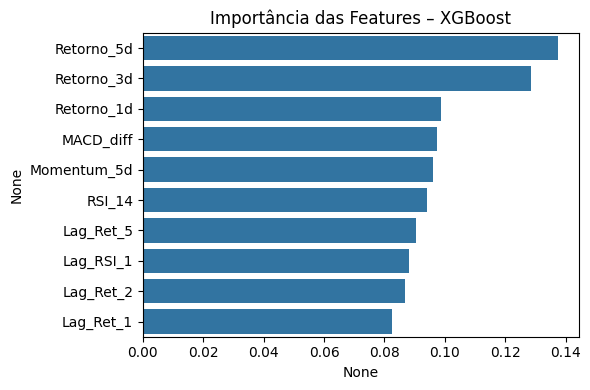

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Carregar os dados ===
df = pd.read_csv("Dados Históricos - Ibovespa.csv")
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# === 2. Tratamento ===
# Corrige colunas numéricas
def convert_volume(valor):
    if 'B' in valor:
        return float(valor.replace(',', '.').replace('B', '')) * 1_000_000_000
    elif 'M' in valor:
        return float(valor.replace(',', '.').replace('M', '')) * 1_000_000
    else:
        return float(valor.replace(',', '.'))

df['Vol.'] = df['Vol.'].apply(convert_volume)

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

df['Var%'] = df['Var%'].astype(str).str.replace(',', '.').str.replace('%', '').astype(float)
df = df.sort_values('Data').reset_index(drop=True)

# === 3. Features básicas ===
df['Retorno_1d'] = df['Último'].pct_change(1)
df['Retorno_3d'] = df['Último'].pct_change(3)
df['Retorno_5d'] = df['Último'].pct_change(5)
df['Momentum_5d'] = df['Último'] - df['Último'].shift(5)

# === 4. Indicadores técnicos ===
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series, short=12, long=26, signal=9):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    macd = ema_short - ema_long
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

df['RSI_14'] = calculate_rsi(df['Último'])
df['MACD'], df['MACD_signal'] = calculate_macd(df['Último'])
df['MACD_diff'] = df['MACD'] - df['MACD_signal']

# === 5. Lags ===
df['Lag_Ret_1'] = df['Retorno_1d'].shift(1)
df['Lag_Ret_2'] = df['Retorno_1d'].shift(2)
df['Lag_Ret_5'] = df['Retorno_1d'].shift(5)
df['Lag_RSI_1'] = df['RSI_14'].shift(1)

# === 6. Target ===
df['Target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

# === 7. Limpeza final ===
df = df.dropna().reset_index(drop=True)

# === 8. Seleção de features ===
features = [
    'Retorno_1d', 'Retorno_3d', 'Retorno_5d',
    'Momentum_5d',
    'RSI_14', 'MACD_diff',
    'Lag_Ret_1', 'Lag_Ret_2', 'Lag_Ret_5', 'Lag_RSI_1'
]

X = df[features]
y = df['Target']

# === 9. Split temporal ===
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# === 10. Modelo ===
model = XGBClassifier(
    max_depth=4,
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# === 11. Avaliação ===
y_pred = model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório:\n", classification_report(y_test, y_pred))

# === 12. Importância das variáveis ===
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Importância das Features – XGBoost")
plt.tight_layout()
plt.show()


In [1]:
pip install imbalanced-learn